In [1]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [190]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [198]:
# run this ceil for different data sets

α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 300
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5


# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

  0.586243 seconds (1.14 M allocations: 2.629 GiB, 10.76% gc time)
Estimation of index coefs: 
̂α => [0.43009738667945774; 0.9027824975992286]
̂γ => [0.15036295435235397, 0.32280650946781764]
Estimation of linear coefs: 
̂θ => [2.005495535395911 -0.9554442970094182]
̂β => [0.8051950236726563, -0.1110186471928848]


In [200]:
model1.categ

6-element Vector{Vector{Float64}}:
 [0.0, 1.0]
 [1.0, 2.0]
 [1.0, 1.0]
 [1.0, 0.0]
 [0.0, 0.0]
 [0.0, 2.0]

# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

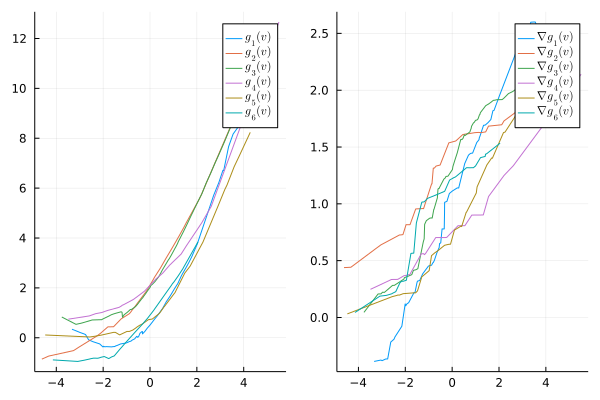

In [199]:
alphap = 1.0 * alpha1
v = X * alphap # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y - X * transpose(theta), τ, -0.4) # g: g(v), dg: g'(v)
p1 = plot()
p2 = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = L"\nabla g_{%$m} (v)")

end
plot(p1, p2, layout = (1,2))



# Monte Carlo Simulation

In [201]:
Threads.nthreads()

2

In [247]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [258]:
α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [1.0, 0.5] # linear for z
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 400
fx = 2
dist = 1 # Cauchy
rep = 100 # MC rept. times

100

In [259]:
Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, τ, fx, dist, rep)

0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:01<Inf:Inf, InfGs/it]
2.0%┣█                                              ┫ 2/100 [00:03<04:14, 3s/it]
3.0%┣█▍                                             ┫ 3/100 [00:04<02:57, 2s/it]
4.0%┣█▉                                             ┫ 4/100 [00:05<02:32, 2s/it]
5.0%┣██▍                                            ┫ 5/100 [00:06<02:18, 1s/it]
6.0%┣██▉                                            ┫ 6/100 [00:07<02:10, 1s/it]
7.0%┣███▎                                           ┫ 7/100 [00:08<02:04, 1s/it]
8.0%┣███▊                                           ┫ 8/100 [00:09<02:00, 1s/it]
9.0%┣████▎                                          ┫ 9/100 [00:10<01:55, 1s/it]
10.0%┣████▌                                        ┫ 10/100 [00:11<01:51, 1s/it]
11.0%┣█████                                        ┫ 11/100 [00:12<01:48, 1s/it]
12.0%┣█████▍                

([0.5268205136891871 0.8499765563568568; 0.25174559228601345 0.9677934473659987; … ; 0.5225276590426726 0.8526223346449378; 0.19949636642771576 0.9798985660680081], [0.11099328833614235 0.21899536898604316; 0.078669465795183 0.2486555791232573; … ; 0.20399015790039826 0.2726722469220735; 0.13662505896473698 0.27353958241714005], [1.8704143252661616 -1.159293898495045; 2.336888151195815 -0.6078789780299833; … ; 1.820514486462702 -1.1156981634321965; 2.426480196688198 -0.4940041747285384], [0.3270698402269337 0.021414528746420136; 0.3763820166336861 0.005439492588997875; … ; 0.3253291889327964 0.013044015947315378; 0.31523408928355223 -0.01850947066534789])

In [260]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 0.286101  -0.00280132

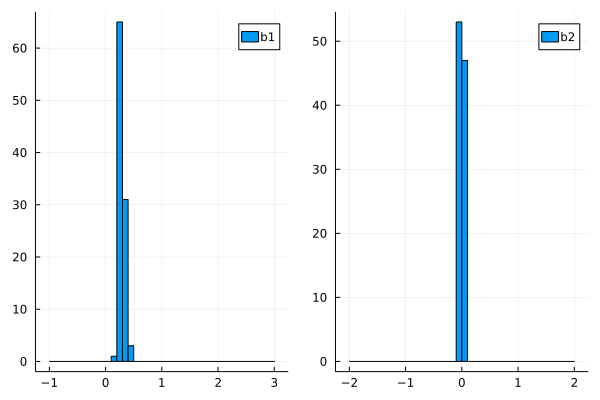

In [261]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

In [257]:
mg = mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.170047  0.299755

In [232]:
(γ |> transpose) ./ mg

1×2 Matrix{Float64}:
 1.0  1.0

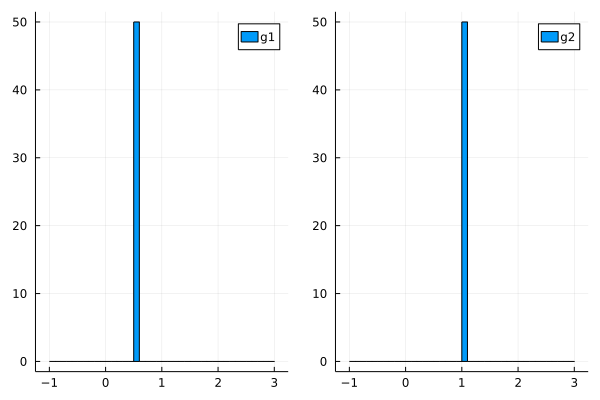

In [233]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

In [236]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.439106  0.89339

In [48]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 2.01907  -0.949599

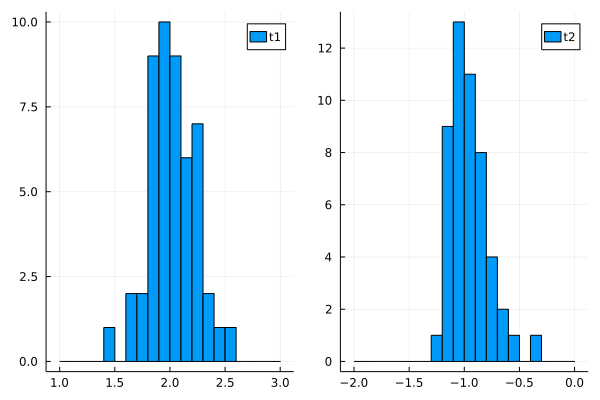

In [49]:
p1 = histogram(Theta[:,1], bins = 1:0.1:3, label = "t1")
p2 = histogram(Theta[:,2], bins = -2:0.1:-0, label = "t2")
plot(p1, p2, layout = (1, 2))

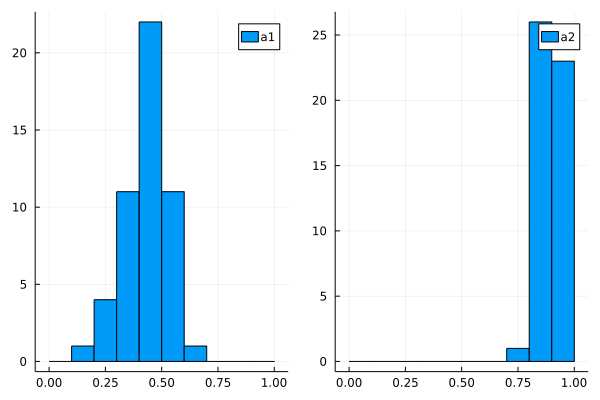

In [50]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))